# Is Perisher Full of Shit?
Do ski resorts artifically inflate their forecasts to increase business?

### Config 

In [1]:
%load_ext autoreload
%autoreload 2

# imports
import getPerisherForecast
import getTableauWrapper

import pandas as pd
import datetime
import os, sys
import sqlite3

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt


# globals
db = "./catch.db"
conn = sqlite3.connect(db)

today = datetime.datetime.strftime(datetime.datetime.today(), '%Y-%m-%d')
print(f"\nLast run: {today}")

You are using the Extract API 2.0, please save the output as .hyper format

Last run: 2020-08-14


### Get Perisher Forecast

In [82]:
perisherWrapper = getPerisherForecast.PerisherWrapper()
df_forecast = perisherWrapper.findPerisherForecast()
print(df_forecast.shape)
df_forecast

(14, 6)


,forecast_date,weather,prob._of_precip,likely_snow,snow_level,wind
0,Fri Aug 14,"Cloudy. Rain, sleet and snow showers",90%,2-5cm,1700,NE
1,Sat Aug 15,Cloudy. Sleet and snow showers clearing,75%,<2cm,1600,SW
2,Sun Aug 16,"Rain, tending to sleet and snow",70%,2-5cm,1600,SW/NW
3,Mon Aug 17,Mostly cloudy. Snow showers,60%,<2cm,1500,NW
4,Tue Aug 18,Windy with snowfalls,90%,15-30cm,1300,N
5,Wed Aug 19,Windy with snowfalls,90%,20-40cm,1100,NW
6,Thu Aug 20,Windy with snowfalls,80%,15-30cm,800,NW
7,Fri Aug 21,Cloudy. Snow showers. Winds easing,90%,5-10cm,900,W
8,Sat Aug 22,Possible snow showers,40%,2-5cm,1000,W
9,Sun Aug 23,Early frost. Mostly sunny,10%,Nil,,NW


### Parse Forecast

In [83]:

df_forecast['forecast_date_parsed'] = df_forecast['forecast_date'].apply(
    lambda x: datetime.datetime.strptime(x+', 2020', '%a %b %d, %Y')
)
df_forecast['likely_snow_discrete'] = df_forecast['likely_snow'].apply(
    perisherWrapper.parseSnowForecast
)
df_forecast['scrapped_date'] = today

df_forecast.to_sql(
    'perisherForecast',
    conn,
    if_exists='append'
)

### Format for Tableau

In [6]:
df_all_forecasts = pd.read_sql(
    '''
    SELECT
        forecast_date, forecast_date_parsed, wind, likely_snow, likely_snow_discrete, scrapped_date
    FROM perisherForecast
    ''',
    conn
)
df_all_forecasts['likely_snow_discrete'] = df_all_forecasts['likely_snow_discrete'].apply(lambda x: float(x))
print(df_all_forecasts.shape)
df_all_forecasts.head()

(14, 6)


,forecast_date,forecast_date_parsed,wind,likely_snow,likely_snow_discrete,scrapped_date
0,Fri Aug 14,2020-08-14 00:00:00,NE,2-5cm,3.5,2020-08-14
1,Sat Aug 15,2020-08-15 00:00:00,SW,<2cm,2.0,2020-08-14
2,Sun Aug 16,2020-08-16 00:00:00,SW/NW,2-5cm,3.5,2020-08-14
3,Mon Aug 17,2020-08-17 00:00:00,NW,<2cm,2.0,2020-08-14
4,Tue Aug 18,2020-08-18 00:00:00,N,15-30cm,22.5,2020-08-14


In [89]:
# write to tableau specific format
getTableauWrapper.makeConversion(df_all_forecasts, "all_forecasts")
getTableauWrapper.cleanLogs()

processing table: 14it [00:00, 5036.04it/s]Table 'Extract' does not exist in extract ./tableau/all_forecasts.hyper, creating.
PYTHON: 14/08/2020 12:29

PYTHON: Directory cleaned
PYTHON: 14/08/2020 12:29



### Vis for Simple Tracking

Text(0.5, 1.0, 'predicted snow fall')

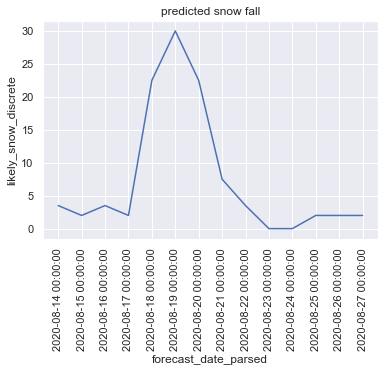

In [10]:
sns.lineplot(x='forecast_date_parsed', y='likely_snow_discrete', data=df_all_forecasts)
plt.xticks(rotation=90)
plt.title('predicted snow fall')